In [1]:
# import requirements
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn import preprocessing

from sklearn.cluster import KMeans, MiniBatchKMeans


In [2]:
def to_labels(original_dataframe, feature_to_encode):
    label_encoder = preprocessing.LabelEncoder()
    original_dataframe[feature_to_encode] = label_encoder.fit_transform(original_dataframe[[feature_to_encode]])
    
    return(original_dataframe)

In [3]:
# Load train and validation datasets and take a look at them.
training_dataset = pd.read_csv('dataset/train.csv')
validation_dataset = pd.read_csv('dataset/validation.csv')
training_dataset.head()

,rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma
0,2.56545,588.590027,VAN,9665.0,2018-01-01 07:00:00,NC_GRE,FL_LAK
1,2.66334,600.750000,VAN,12321.0,2018-01-01 07:00:00,NC_GRE,FL_LAK
2,2.55534,590.919983,VAN,10056.0,2018-01-01 07:00:00,NC_GRE,FL_LAK
3,2.52111,634.640015,VAN,9199.0,2018-01-01 07:00:00,NC_GRE,FL_LAK
4,2.72861,586.380005,VAN,10050.0,2018-01-01 07:00:00,NC_GRE,FL_LAK


In [5]:
# Function for checking the missing values of DataFrame
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [6]:
# It seems we have just 80 rows containing missing values in the training set.
missing_values_table(training_dataset)

Your selected dataframe has 7 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
weight,80,0.0


In [7]:
#and 0 rows in the validation set
missing_values_table(validation_dataset)

Your selected dataframe has 7 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [8]:
# We can replace NANs with mean values
training_dataset.weight.fillna(training_dataset.weight.mean(), inplace=True)

In [9]:
#merge training and validation sets
training_size = training_dataset.shape[0] #variable to store a break between merged training + validation sets
df = training_dataset.append(validation_dataset).reset_index(drop=True)

In [10]:
# Extracting 'month', 'day' and 'isMorning' from 'pickup_date' feature.
df['month'] = pd.DatetimeIndex(df['pickup_date']).month_name()
df['day'] = pd.DatetimeIndex(df['pickup_date']).day_name()
df['time'] = pd.to_datetime(df['pickup_date']).dt.strftime("%p")

df.loc[df['time'] == "AM", 'isMorning'] = 1
df.loc[df['time'] == "PM", 'isMorning'] = 0

df['isMorning'] = df['isMorning'].astype('object')

df = df.drop(['pickup_date', 'time'], axis = 1)

In [11]:
# Take a look ot these new features
df[['month', 'day', 'isMorning']].describe()

,month,day,isMorning
count,301727,301727,301727.0
unique,12,7,2.0
top,October,Friday,1.0
freq,29074,60068,182912.0



## Feature-Feature relationships
We have some numeric features and many categorical features. For numeric features, it's good to know about distribution, regardless of other features and relationships between them. First we will take a look at linear relationships using scatter plot and correlation analysis.

In [12]:
# Extract numeric features
num_feats = df[['valid_miles', 'weight']].copy()
num_feats.head()

,valid_miles,weight
0,588.590027,9665.0
1,600.750000,12321.0
2,590.919983,10056.0
3,634.640015,9199.0
4,586.380005,10050.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d3d4250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1d2d7750>]], dtype=object)

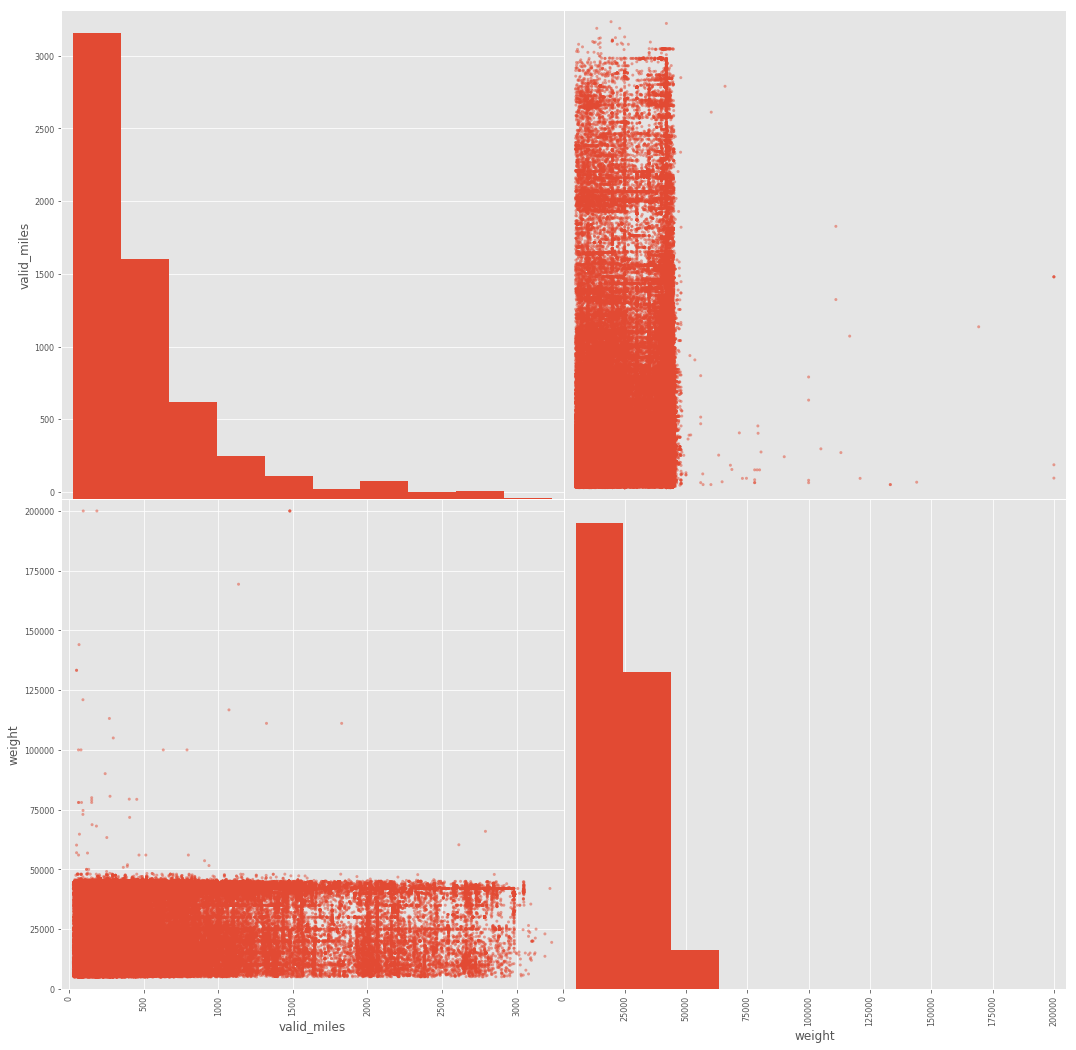

In [13]:
# PLot scatter matrix for numeric features
%matplotlib inline
pd.plotting.scatter_matrix(num_feats, figsize=(18, 18))

In [14]:
#Calculate correlations
pd.concat([num_feats, df['rate']], axis=1).corr()

,valid_miles,weight,rate
valid_miles,1.000000,0.200289,-0.394106
weight,0.200289,1.000000,-0.076346
rate,-0.394106,-0.076346,1.000000


Now, it's categorical variables' turn. Correlation analysis between two categorical variables can be implemented through chi-square test. So I wrote a function that implements chi-square test on categorical variables and calculates p-values for null hypothesis that the two variables are independent, so if chi-square test for two given categorical variables is lower than 0.05, we can reject the null hypothesis and bravely conclude that these variables are dependent.

In [15]:
# Create a copy of categorical variables
cat_feats = df.select_dtypes(include='object').copy()
cat_feats.head()

,transport_type,origin_kma,destination_kma,month,day,isMorning
0,VAN,NC_GRE,FL_LAK,January,Monday,1
1,VAN,NC_GRE,FL_LAK,January,Monday,1
2,VAN,NC_GRE,FL_LAK,January,Monday,1
3,VAN,NC_GRE,FL_LAK,January,Monday,1
4,VAN,NC_GRE,FL_LAK,January,Monday,1


In [16]:
# Defining a function for implementing chi-square test on categorical features
from scipy import stats
def chi_square_test(df):
    
    # Function for implementing chi-square independence test on two series representing two cat features
    def get_chi2(column1, column2):
        
        # Create contingency table
        con_table = pd.crosstab(column1, column2)
        
        # Calculate chi2 test
        chi2, p, degree_f, expected = stats.chi2_contingency(con_table)
        return chi2, p, degree_f, expected
        
    # Extract categorical features
    cat_features = df.select_dtypes(include='object')
    
    # Implementing chi-squared test on cat features
    cols = cat_features.columns.tolist()
    table = list()
    for col1 in cols:
        l = list()
        for col2 in cols:
            chi2, p, degree_f, expected = get_chi2(df[col1], df[col2])
            if (expected < 5).any():    # If there is any <5 elemnt in expected array, test isn't trustable
                l.append(np.nan)
            else:
                l.append(p)
        table.append(l)
    return pd.DataFrame(table, columns=cols, index=cols)

In [17]:
chi_square_test(cat_feats)

,transport_type,origin_kma,destination_kma,month,day,isMorning
transport_type,0.000000e+00,NaN,NaN,8.425399e-65,0.000000e+00,1.053416e-31
origin_kma,NaN,NaN,NaN,NaN,NaN,NaN
destination_kma,NaN,NaN,NaN,NaN,NaN,NaN
month,8.425399e-65,NaN,NaN,0.000000e+00,7.604816e-301,9.784964e-111
day,0.000000e+00,NaN,NaN,7.604816e-301,0.000000e+00,3.212637e-101
isMorning,1.053416e-31,NaN,NaN,9.784964e-111,3.212637e-101,0.000000e+00


In [18]:
# Drop month and isMorning because of having too much dependency with other features
chi_square_test(cat_feats.drop(['month', 'isMorning'], axis=1))

,transport_type,origin_kma,destination_kma,day
transport_type,0.0,NaN,NaN,0.0
origin_kma,NaN,NaN,NaN,NaN
destination_kma,NaN,NaN,NaN,NaN
day,0.0,NaN,NaN,0.0


In [19]:
df.drop(['month', 'day', 'isMorning'], inplace=True, axis=1)
df.columns

Index([u'rate', u'valid_miles', u'transport_type', u'weight', u'origin_kma',
       u'destination_kma'],
      dtype='object')

In [21]:
#labeling for categorical features
features_to_label = ['transport_type', 'origin_kma', 'destination_kma']
for feature in features_to_label:
    df = to_labels(df, feature)

# Feature-Output relationships

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1633bc10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a17267050>]], dtype=object)

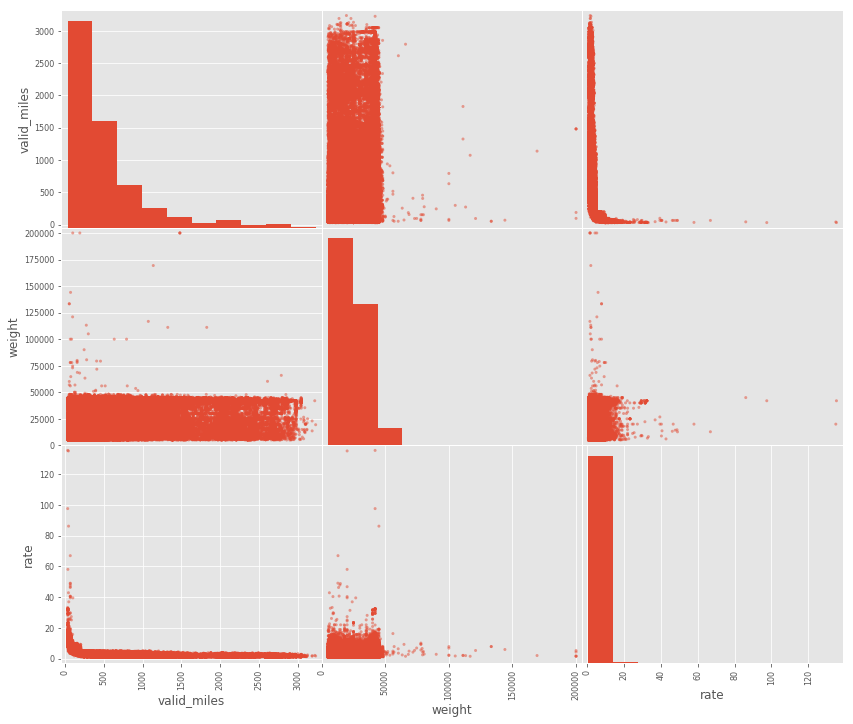

In [22]:
num_feats['rate'] = df['rate'].copy()
%matplotlib inline
plt.style.use('ggplot')
pd.plotting.scatter_matrix(num_feats, figsize=(14, 12))

We can see realationship between rate and valid_miles, let's try to make this relationship more linear.
Also important to notice the distributions are skewed, let's add log, sqrt, 1/x transformed forms of rate and valid_miles:

In [23]:
# Add new features
num_feats['logRate'] = np.log(num_feats['rate'])
num_feats['sqrtRate'] = np.sqrt(num_feats['rate'])
num_feats['1/rate'] = 1/num_feats['rate']

num_feats['logMiles'] = np.log1p(num_feats['valid_miles'])
num_feats['sqrtMiles'] = np.sqrt(num_feats['valid_miles'])
num_feats['1/miles'] = 1/num_feats['valid_miles']

In [ ]:
pd.plotting.scatter_matrix(num_feats[['valid_miles',
                                     'rate',
                                     'logRate',
                                     'sqrtRate',
                                     '1/rate',
                                     'logMiles',
                                     'sqrtMiles',
                                     '1/miles']], figsize=(14, 12))

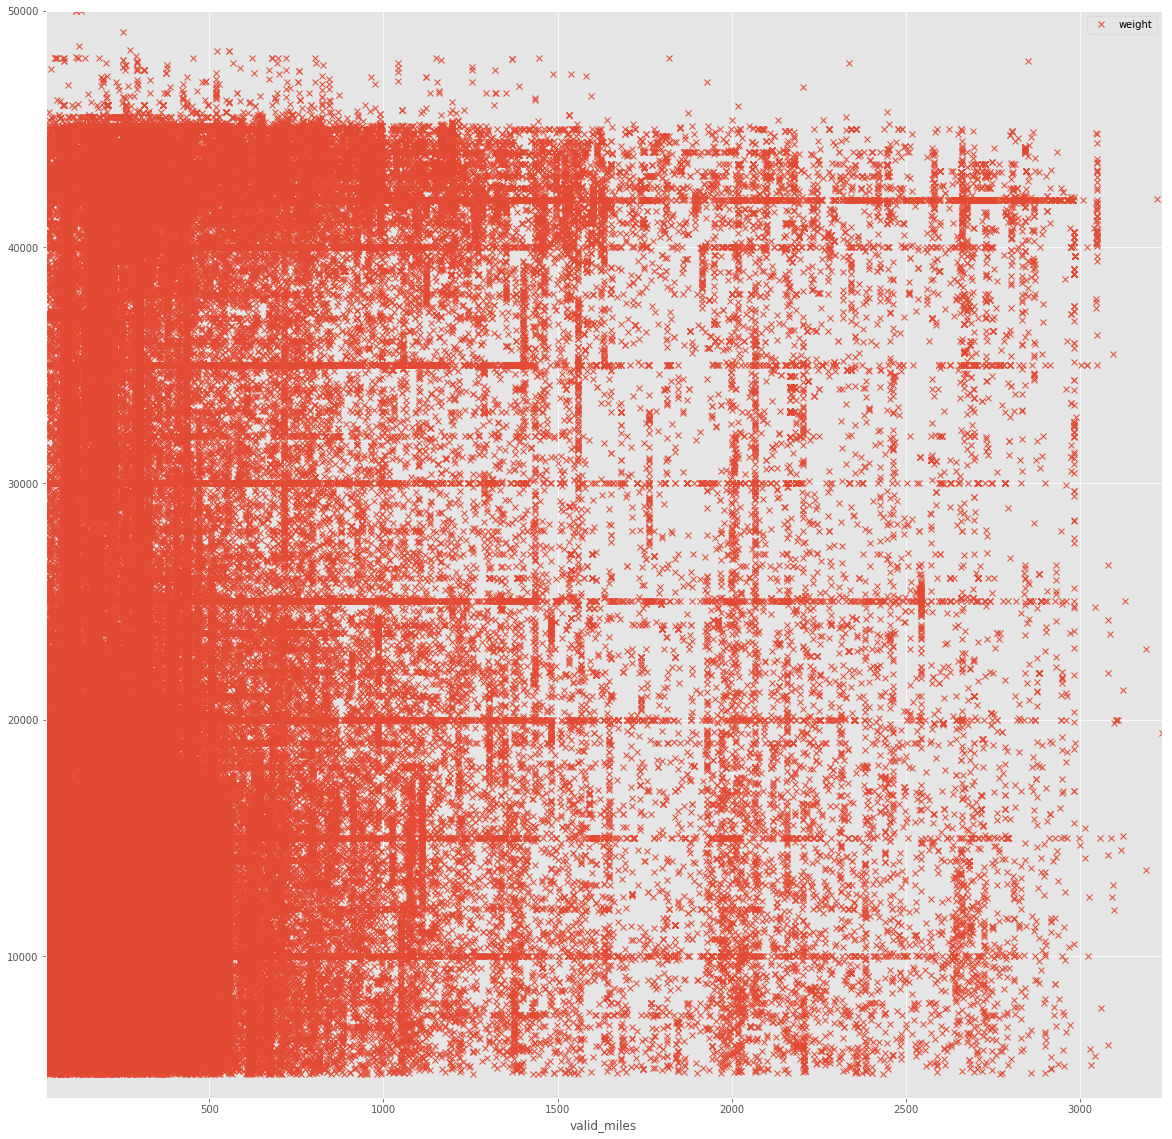

In [24]:
num_feats.plot(x='valid_miles', y='weight', style='x', ylim = (4000,50000), figsize=(20,20))

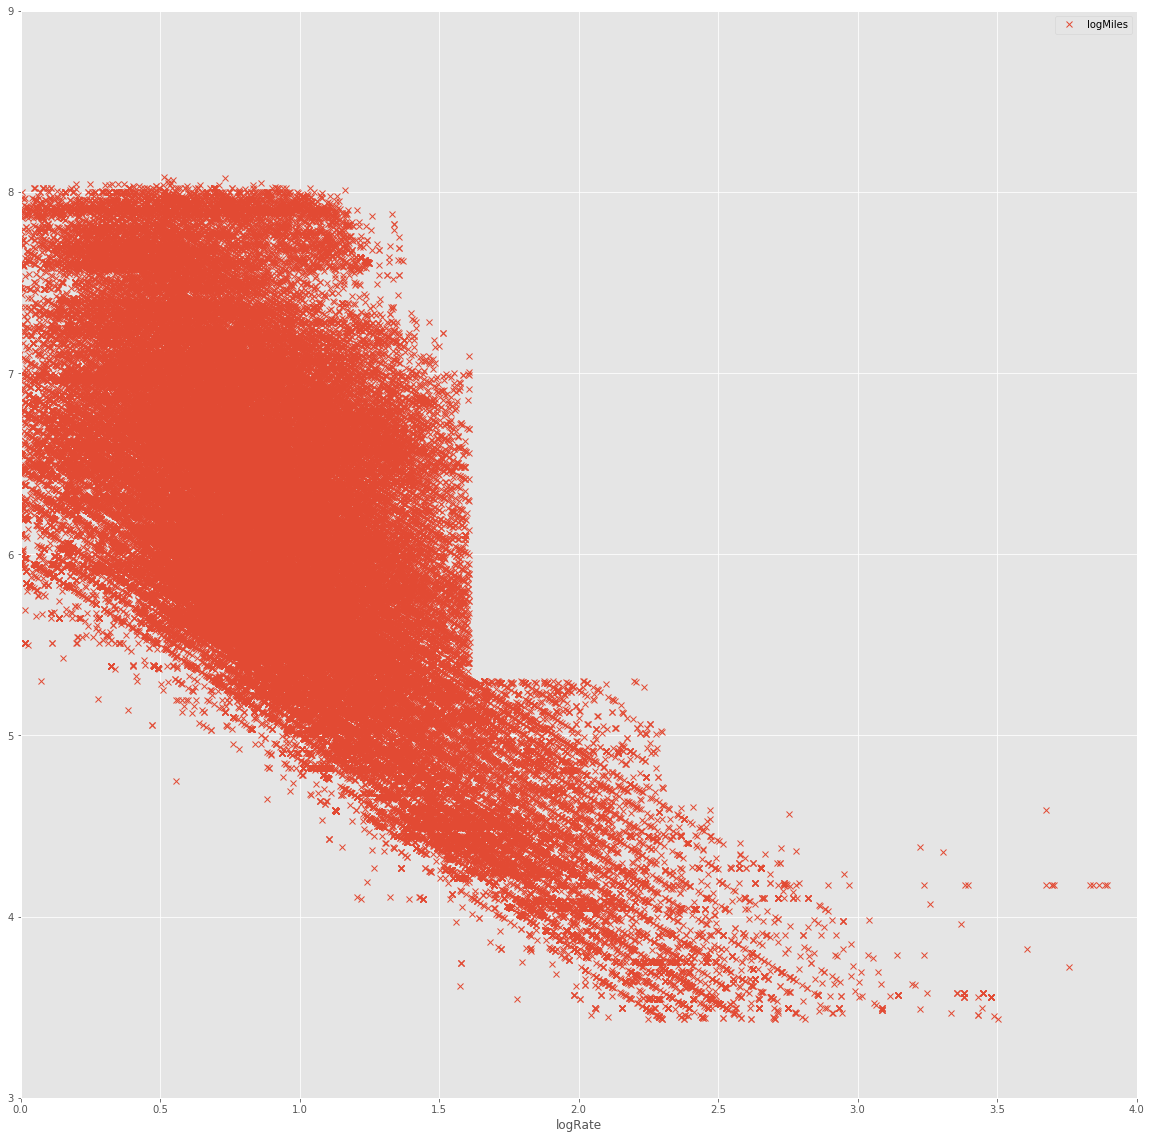

In [25]:
num_feats.plot(x='logRate', y='logMiles', style='x', ylim = (3,9), xlim=(0,4), figsize=(20,20))

We can see a near normal distribution for logMiles and logRate features, and the scatterplot for these features shows a better linear relationship.
As you can see, we can take the weight feature as a categorical feature by clustering. so we will add logMiles and logRate to df, and make weight a categorical feature.

In [26]:
kmeans = MiniBatchKMeans(n_clusters = 8, batch_size=10000, random_state = 0).fit(num_feats[['weight']])
df['weight_cluster'] = kmeans.predict(num_feats[['weight']])

(0, 20)

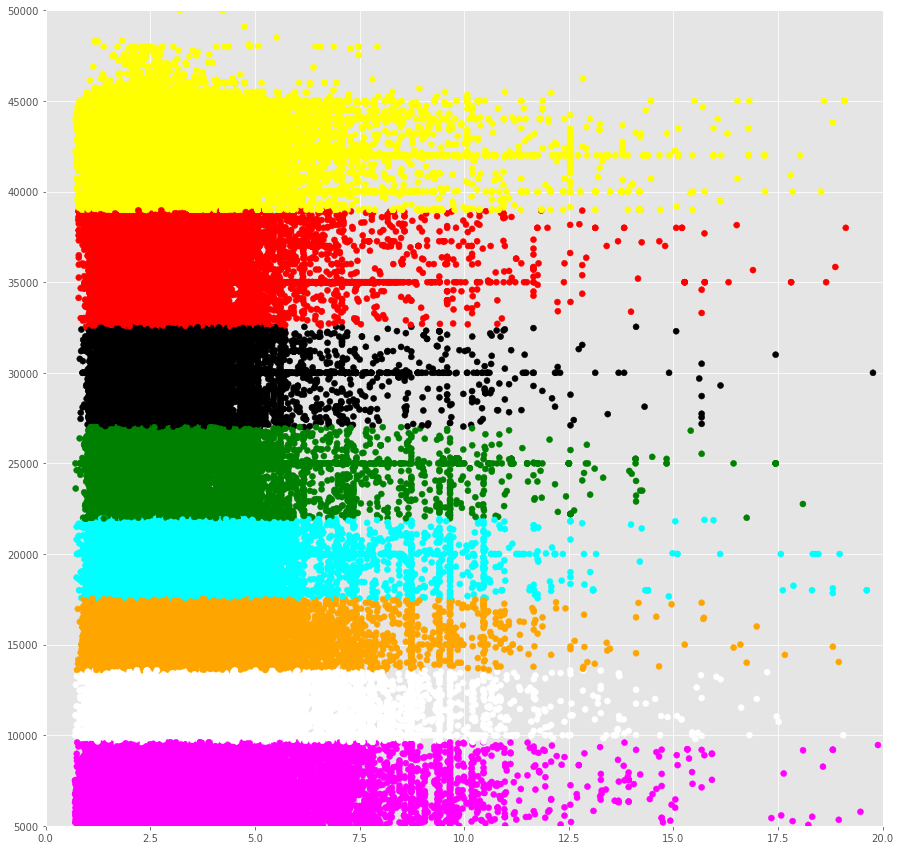

In [27]:
x = num_feats['rate'].values
y = num_feats['weight'].values
label = kmeans.predict(num_feats[['weight']])
colors = ['red','orange','yellow','green', 'blue', 'magenta', 'cyan', 'black', 'white']

fig = plt.figure(figsize=(15,15))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

plt.ylim(5000, 50000)
plt.xlim(0,20)


In [28]:
# Add two new near normal features
df['log_rate'] = np.log(df['rate'])
df['log_miles'] = np.log(df['valid_miles'])    

cat_feats['weight_cluster'] = df['weight_cluster'].copy()

In [29]:
# Function for plotting the price distributions of grouped data by value of a feature
def plot_kde(df, groupby_var, output_var):
    %matplotlib inline
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
    c = [(i[0]/255., i[1]/255., i[2]/255.) for i in tableau20]
    g = df.groupby(groupby_var)
    for i, group in enumerate(g.groups.keys()):
        subset = g.get_group(group)[output_var]
        subset.plot.density(color=c[i])
    plt.legend(g.groups.keys())
    plt.title('KDE for {}, groupped by {}'.format(output_var, groupby_var))

def plot_box(df, by, column):
    %matplotlib inline
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
    c = [(i[0]/255., i[1]/255., i[2]/255.) for i in tableau20]
    df.boxplot(by=by, column=column, notch=True, vert=True, patch_artist=True, figsize=(16, 8), rot=90)

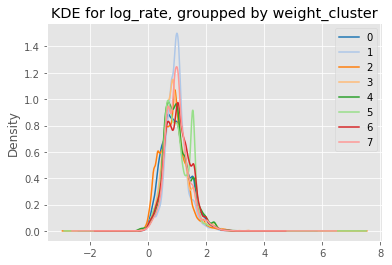

In [30]:
plot_kde(df, 'weight_cluster', 'log_rate')


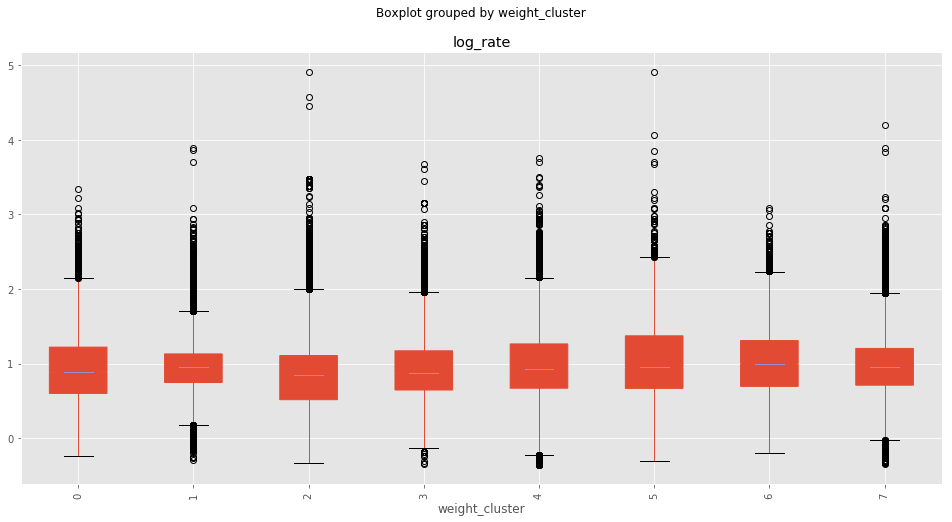

In [31]:
plot_box(df, 'weight_cluster', 'log_rate')


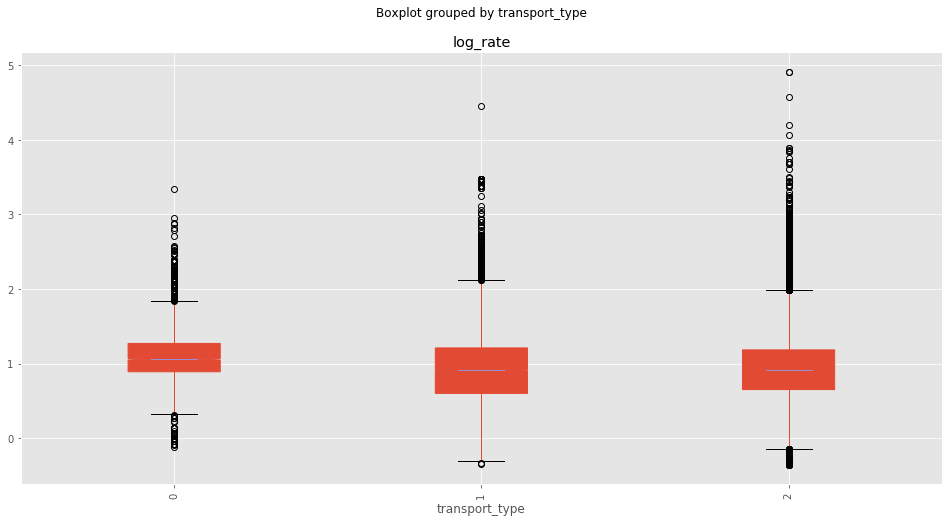

In [32]:
plot_box(df, 'transport_type', 'log_rate')


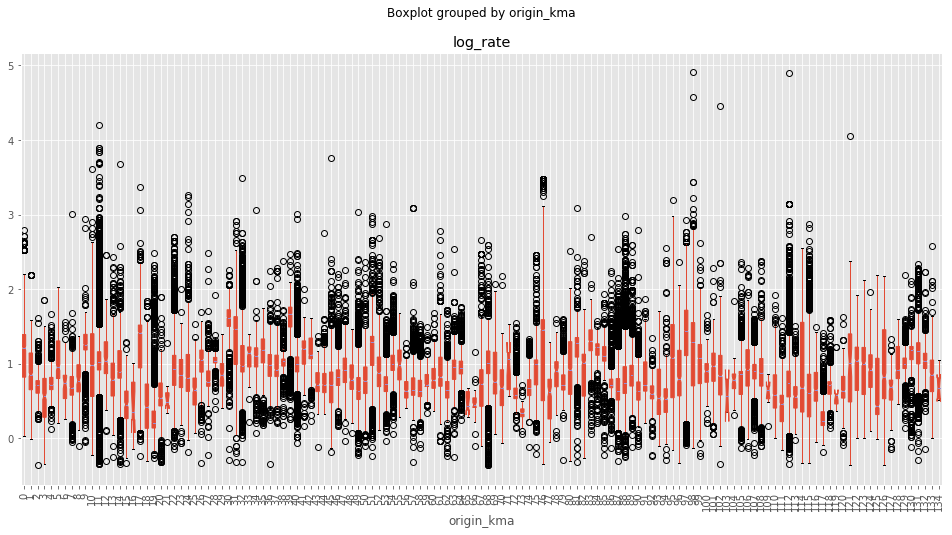

In [34]:
plot_box(df, 'origin_kma', 'log_rate')


In [35]:
df

,rate,valid_miles,transport_type,weight,origin_kma,destination_kma,weight_cluster,log_rate,log_miles
0,2.56545,588.590027,2,9665.0,68,19,7,0.942134,6.377730
1,2.66334,600.750000,2,12321.0,68,19,7,0.979581,6.398179
2,2.55534,590.919983,2,10056.0,68,19,7,0.938185,6.381681
3,2.52111,634.640015,2,9199.0,68,19,4,0.924699,6.453058
4,2.72861,586.380005,2,10050.0,68,19,7,1.003792,6.373968
5,1.32461,641.700012,2,11646.0,112,113,7,0.281118,6.464121
6,1.75591,425.989990,2,13098.0,5,115,7,0.562987,6.054416
7,2.25564,266.000000,2,7855.0,112,110,4,0.813434,5.583496
8,2.52653,277.059998,2,9926.0,112,91,7,0.926847,5.624234
9,2.63148,266.010010,2,13175.0,112,91,7,0.967546,5.583534
